In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
from matplotlib import cm
import seaborn as sns
import feature_processing as fp

%matplotlib inline

In [2]:
from imblearn.under_sampling import TomekLinks, RandomUnderSampler
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_curve, precision_recall_curve
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import make_scorer
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV

In [3]:
def my_gini(y_true, y_probas):
    auc = roc_auc_score(y_true, y_probas[:, 1])
    gini = 2*auc - 1
    return gini

gini_scorer = make_scorer(my_gini, needs_proba=True, greater_is_better=True)

In [11]:
train_ori = pd.read_csv('train.csv', header=0)
train = pd.read_csv('./data/train_probas.csv', header=0)
target = train_ori.target
print('Train Set Shape: ', train.shape)
print('Features: \n', train.columns)

Train Set Shape:  (595212, 31)
Features: 
 Index(['ps_calc_01_proba', 'ps_calc_02_proba', 'ps_calc_03_proba',
       'ps_calc_04_proba', 'ps_calc_05_proba', 'ps_calc_06_proba',
       'ps_calc_07_proba', 'ps_calc_08_proba', 'ps_calc_09_proba',
       'ps_calc_10_proba', 'ps_calc_11_proba', 'ps_calc_12_proba',
       'ps_calc_13_proba', 'ps_calc_14_proba', 'ps_car_11_proba',
       'ps_car_12_proba', 'ps_car_13_proba', 'ps_car_14_proba',
       'ps_car_15_proba', 'ps_ind_01_proba', 'ps_ind_03_proba',
       'ps_ind_14_proba', 'ps_ind_15_proba', 'ps_reg_01_proba',
       'ps_reg_02_proba', 'ps_reg_03_proba', 'ind_bin_proba', 'calc_bin_proba',
       'car_cat_proba1', 'car_cat_proba2', 'ind_cat_proba'],
      dtype='object')


In [12]:
num_samples = len(train_ori.target)
num_target = np.sum(train_ori.target)
freq_target = num_target/num_samples
freq_target

0.036447517859182946

In [13]:
used_fs = list(train.columns)
used_fs.remove('calc_bin_proba')
used_fs.remove('ps_calc_01_proba')
used_fs.remove('ps_calc_02_proba')
used_fs.remove('ps_calc_03_proba')
used_fs.remove('ps_calc_04_proba')
used_fs.remove('ps_calc_06_proba')
used_fs.remove('ps_calc_08_proba')
used_fs.remove('ps_calc_09_proba')

In [14]:
print(used_fs)

['ps_calc_05_proba', 'ps_calc_07_proba', 'ps_calc_10_proba', 'ps_calc_11_proba', 'ps_calc_12_proba', 'ps_calc_13_proba', 'ps_calc_14_proba', 'ps_car_11_proba', 'ps_car_12_proba', 'ps_car_13_proba', 'ps_car_14_proba', 'ps_car_15_proba', 'ps_ind_01_proba', 'ps_ind_03_proba', 'ps_ind_14_proba', 'ps_ind_15_proba', 'ps_reg_01_proba', 'ps_reg_02_proba', 'ps_reg_03_proba', 'ind_bin_proba', 'car_cat_proba1', 'car_cat_proba2', 'ind_cat_proba']


In [15]:
X = np.array(train[used_fs])
y = np.array(target)

In [16]:
X.shape, y.shape

((595212, 23), (595212,))

# Tuning XGBoost

In [17]:
rstate = 55

# Set targets for the number of each class
num_class1 = np.sum(y)
num_class1_to_resample = 2 * num_class1
num_class0_to_resample = int(1 * num_class1_to_resample)

# First, randomly undersample the majority
rus = RandomUnderSampler(ratio={0: num_class0_to_resample , 1: num_class1})
X_tlrus, y_tlrus = rus.fit_sample(X, y)

# Then use SMOTE to oversample the minority
smote = SMOTE(ratio={0: num_class0_to_resample , 1: num_class1_to_resample}, n_jobs=4)
X_res, y_res = smote.fit_sample(X_tlrus, y_tlrus)

## Gamma

<b>Round1</b>

In [18]:
%%time
xgb = XGBClassifier(max_depth=8, colsample_bytree=0.5, n_estimators=200, n_jobs=8)
parameters = {'gamma':[0, 0.5, 1, 2, 4, 8, 16]}
clf = GridSearchCV(xgb, parameters, scoring=gini_scorer, cv=4, verbose=1, n_jobs=1)
clf.fit(X_res, y_res)

Fitting 4 folds for each of 7 candidates, totalling 28 fits


[Parallel(n_jobs=1)]: Done  28 out of  28 | elapsed:  1.2min finished


CPU times: user 10min 20s, sys: 143 ms, total: 10min 20s
Wall time: 1min 18s


In [21]:
pd.DataFrame(clf.cv_results_).sort_values('rank_test_score', ascending=True)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_gamma,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,split3_test_score,split3_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
6,2.449769,0.029700,0.653379,0.679284,16,{'gamma': 16},1,0.313039,0.787940,0.301058,0.790185,0.999696,0.570851,0.999724,0.568160,0.143552,0.001167,0.346357,0.109786
5,2.452895,0.039162,0.652474,0.714112,8,{'gamma': 8},2,0.312531,0.815232,0.297645,0.815442,0.999885,0.614149,0.999833,0.611627,0.140462,0.001138,0.347425,0.101229
4,2.512664,0.047619,0.647898,0.790850,4,{'gamma': 4},3,0.300641,0.871670,0.291148,0.875085,0.999924,0.706053,0.999879,0.710592,0.189395,0.001106,0.352019,0.082552
3,2.471373,0.048881,0.647821,0.824032,2,{'gamma': 2},4,0.304157,0.898818,0.287307,0.901641,0.999911,0.745874,0.999909,0.749795,0.133742,0.001147,0.352139,0.076217
0,2.583085,0.049270,0.647036,0.828695,0,{'gamma': 0},5,0.299906,0.906190,0.288523,0.908019,0.999791,0.741793,0.999926,0.758776,0.272114,0.000908,0.352845,0.078642
1,2.474842,0.049909,0.646623,0.832511,0.5,{'gamma': 0.5},6,0.299208,0.911348,0.287475,0.909269,0.999895,0.756039,0.999914,0.753389,0.137142,0.001001,0.353306,0.077806
2,2.465114,0.049071,0.645294,0.827073,1,{'gamma': 1},7,0.296931,0.909865,0.284458,0.900939,0.999866,0.751936,0.999922,0.745550,0.130281,0.000607,0.354627,0.078426


In [20]:
clf.best_params_

{'gamma': 16}

<b>Round2</b>

In [22]:
%%time
xgb = XGBClassifier(max_depth=8, colsample_bytree=0.5, n_estimators=200, n_jobs=8)
parameters = {'gamma':[14, 15, 16, 17, 18, 19, 20]}
clf = GridSearchCV(xgb, parameters, scoring=gini_scorer, cv=4, verbose=2, n_jobs=1)
clf.fit(X_res, y_res)

Fitting 4 folds for each of 7 candidates, totalling 28 fits
[CV] gamma=14 ........................................................
[CV] ......................................... gamma=14, total=   3.2s
[CV] gamma=14 ........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.3s remaining:    0.0s


[CV] ......................................... gamma=14, total=   2.6s
[CV] gamma=14 ........................................................
[CV] ......................................... gamma=14, total=   2.4s
[CV] gamma=14 ........................................................
[CV] ......................................... gamma=14, total=   2.4s
[CV] gamma=15 ........................................................
[CV] ......................................... gamma=15, total=   2.7s
[CV] gamma=15 ........................................................
[CV] ......................................... gamma=15, total=   2.7s
[CV] gamma=15 ........................................................
[CV] ......................................... gamma=15, total=   2.4s
[CV] gamma=15 ........................................................
[CV] ......................................... gamma=15, total=   2.4s
[CV] gamma=16 ........................................................
[CV] .

[Parallel(n_jobs=1)]: Done  28 out of  28 | elapsed:  1.3min finished


CPU times: user 10min 59s, sys: 335 ms, total: 10min 59s
Wall time: 1min 24s


In [23]:
pd.DataFrame(clf.cv_results_).sort_values('rank_test_score', ascending=True)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_gamma,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,split3_test_score,split3_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,2.629913,0.031713,0.655342,0.682566,14,{'gamma': 14},1,0.317010,0.789783,0.304780,0.791627,0.999846,0.574381,0.999734,0.574476,0.351451,0.000511,0.344475,0.108140
1,2.503843,0.030724,0.654943,0.680920,15,{'gamma': 15},2,0.315266,0.788290,0.304990,0.790470,0.999808,0.572620,0.999706,0.572301,0.153285,0.000765,0.344834,0.108463
3,2.547935,0.030323,0.653818,0.678770,17,{'gamma': 17},3,0.314085,0.787272,0.301792,0.789474,0.999775,0.569258,0.999620,0.569074,0.117287,0.000659,0.345907,0.109606
6,3.973806,0.029811,0.653813,0.677283,20,{'gamma': 20},4,0.313306,0.786294,0.302643,0.788103,0.999737,0.567352,0.999567,0.567383,1.092654,0.001633,0.345859,0.109917
4,2.551605,0.030138,0.653477,0.678428,18,{'gamma': 18},5,0.313671,0.787343,0.300844,0.788654,0.999690,0.569191,0.999702,0.568525,0.106891,0.001047,0.346249,0.109572
2,2.485035,0.029735,0.653379,0.679284,16,{'gamma': 16},6,0.313039,0.787940,0.301058,0.790185,0.999696,0.570851,0.999724,0.568160,0.139256,0.001345,0.346357,0.109786
5,2.530990,0.028808,0.653156,0.677588,19,{'gamma': 19},7,0.313090,0.786721,0.300190,0.788174,0.999673,0.567837,0.999671,0.567620,0.174037,0.001054,0.346546,0.109861


In [24]:
clf.best_params_

{'gamma': 14}

<b>Round3</b>

In [25]:
%%time
xgb = XGBClassifier(max_depth=8, colsample_bytree=0.5, n_estimators=200, n_jobs=8)
parameters = {'gamma':[12, 13, 14]}
clf = GridSearchCV(xgb, parameters, scoring=gini_scorer, cv=3, verbose=1, n_jobs=1)
clf.fit(X_res, y_res)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   21.0s finished


CPU times: user 3min 13s, sys: 47.7 ms, total: 3min 13s
Wall time: 24.4 s


In [26]:
pd.DataFrame(clf.cv_results_).sort_values('rank_test_score', ascending=True)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_gamma,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,2.265459,0.042089,0.653978,0.687695,12,{'gamma': 12},1,0.311302,0.848408,0.651269,0.688580,0.999386,0.526097,0.271981,0.001171,0.280914,0.131584
1,2.167287,0.041582,0.653789,0.686061,13,{'gamma': 13},2,0.310976,0.848071,0.651232,0.687008,0.999183,0.523106,0.150094,0.002028,0.280964,0.132668
2,2.189132,0.040832,0.653158,0.684199,14,{'gamma': 14},3,0.309373,0.846053,0.650921,0.685162,0.999205,0.521381,0.168600,0.000228,0.281625,0.132548


In [27]:
clf.best_params_

{'gamma': 12}

<b>Round4</b>

In [28]:
%%time
xgb = XGBClassifier(max_depth=8, colsample_bytree=0.5, n_estimators=200, n_jobs=8)
parameters = {'gamma':[11, 11.5, 12, 12.5, 13]}
clf = GridSearchCV(xgb, parameters, scoring=gini_scorer, cv=3, verbose=1, n_jobs=1)
clf.fit(X_res, y_res)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:   37.8s finished


CPU times: user 5min 31s, sys: 262 ms, total: 5min 32s
Wall time: 42.6 s


In [29]:
pd.DataFrame(clf.cv_results_).sort_values('rank_test_score', ascending=True)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_gamma,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
2,2.514440,0.041428,0.653978,0.687695,12,{'gamma': 12},1,0.311302,0.848408,0.651269,0.688580,0.999386,0.526097,0.446070,0.001032,0.280914,0.131584
3,2.667029,0.042880,0.653962,0.686548,12.5,{'gamma': 12.5},2,0.311346,0.848204,0.651329,0.688370,0.999235,0.523071,0.543300,0.002196,0.280834,0.132741
0,2.336222,0.043903,0.653950,0.692173,11,{'gamma': 11},3,0.310849,0.851225,0.651635,0.693231,0.999389,0.532063,0.154089,0.000284,0.281098,0.130299
1,2.208923,0.042993,0.653914,0.689545,11.5,{'gamma': 11.5},4,0.311459,0.850482,0.650972,0.689821,0.999336,0.528331,0.186620,0.001937,0.280831,0.131518
4,2.205669,0.041892,0.653789,0.686061,13,{'gamma': 13},5,0.310976,0.848071,0.651232,0.687008,0.999183,0.523106,0.135290,0.001624,0.280964,0.132668


In [30]:
clf.best_params_

{'gamma': 12}

## max_depth

<b>Round1</b>

In [31]:
%%time
xgb = XGBClassifier(gamma=12, colsample_bytree=0.5, n_estimators=200, n_jobs=8)
parameters = {'max_depth':[4, 5, 6, 7, 8, 9, 10]}
clf = GridSearchCV(xgb, parameters, scoring=gini_scorer, cv=3, verbose=1, n_jobs=1)
clf.fit(X_res, y_res)

Fitting 3 folds for each of 7 candidates, totalling 21 fits


[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:   44.9s finished


CPU times: user 6min 29s, sys: 130 ms, total: 6min 29s
Wall time: 49.4 s


In [34]:
pd.DataFrame(clf.cv_results_).sort_values('rank_test_score', ascending=True)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_max_depth,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
6,3.220155,0.053107,0.654131,0.698337,10,{'max_depth': 10},1,0.310939,0.857767,0.652095,0.697280,0.999382,0.539965,0.577184,0.005438,0.281058,0.129744
4,2.219281,0.041664,0.653978,0.687695,8,{'max_depth': 8},2,0.311302,0.848408,0.651269,0.688580,0.999386,0.526097,0.161329,0.000853,0.280914,0.131584
5,2.515114,0.044897,0.653869,0.692023,9,{'max_depth': 9},3,0.310600,0.851954,0.651876,0.692805,0.999155,0.531311,0.171466,0.000325,0.281103,0.130903
3,1.921760,0.041282,0.653212,0.683291,7,{'max_depth': 7},4,0.310244,0.845258,0.650325,0.685639,0.999089,0.518974,0.149112,0.002785,0.281226,0.133216
2,1.636504,0.036401,0.652849,0.678246,6,{'max_depth': 6},5,0.310773,0.842128,0.650007,0.679774,0.997790,0.512837,0.119862,0.004852,0.280479,0.134437
1,1.421727,0.031471,0.652691,0.673707,5,{'max_depth': 5},6,0.311246,0.839186,0.649545,0.675233,0.997305,0.506701,0.131934,0.002237,0.280090,0.135741
0,1.206690,0.027192,0.651232,0.669100,4,{'max_depth': 4},7,0.309671,0.835049,0.649628,0.672271,0.994420,0.499980,0.230564,0.001896,0.279548,0.136810


In [33]:
clf.best_params_

{'max_depth': 10}

<b>Round2</b>

In [35]:
%%time
xgb = XGBClassifier(gamma=12, colsample_bytree=0.5, n_estimators=200, n_jobs=8)
parameters = {'max_depth':[10, 12, 14, 16, 18, 20]}
clf = GridSearchCV(xgb, parameters, scoring=gini_scorer, cv=3, verbose=1, n_jobs=1)
clf.fit(X_res, y_res)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:  1.6min finished


CPU times: user 12min 59s, sys: 355 ms, total: 12min 59s
Wall time: 1min 39s


In [36]:
pd.DataFrame(clf.cv_results_).sort_values('rank_test_score', ascending=True)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_max_depth,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
1,3.545010,0.052264,0.654284,0.706064,12,{'max_depth': 12},1,0.311310,0.860683,0.652222,0.708008,0.999344,0.549500,0.195980,0.001788,0.280891,0.127048
0,2.909013,0.049367,0.654131,0.698337,10,{'max_depth': 10},2,0.310939,0.857767,0.652095,0.697280,0.999382,0.539965,0.332388,0.002395,0.281058,0.129744
2,4.899714,0.062454,0.653193,0.719110,14,{'max_depth': 14},3,0.307130,0.871590,0.652996,0.717180,0.999477,0.568560,1.006761,0.002431,0.282648,0.123719
5,6.508980,0.081721,0.652783,0.742162,20,{'max_depth': 20},4,0.305946,0.883332,0.652817,0.739514,0.999610,0.603640,0.265277,0.000315,0.283185,0.114199
3,4.909323,0.068806,0.652606,0.726492,16,{'max_depth': 16},5,0.307241,0.875190,0.650998,0.727948,0.999602,0.576337,0.222700,0.001646,0.282656,0.122011
4,7.322566,0.092848,0.652253,0.733587,18,{'max_depth': 18},6,0.305256,0.877384,0.651988,0.734976,0.999540,0.588401,1.208798,0.023632,0.283439,0.117981


In [37]:
clf.best_params_

{'max_depth': 12}

## min_child_weight

In [38]:
%%time
xgb = XGBClassifier(gamma=12, max_depth=12, colsample_bytree=0.5, n_estimators=200, n_jobs=8)
parameters = {'min_child_weight':[1, 2, 3, 4, 5, 6]}
clf = GridSearchCV(xgb, parameters, scoring=gini_scorer, cv=3, verbose=1, n_jobs=1)
clf.fit(X_res, y_res)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:  1.5min finished


CPU times: user 11min 55s, sys: 693 ms, total: 11min 56s
Wall time: 1min 34s


In [39]:
pd.DataFrame(clf.cv_results_).sort_values('rank_test_score', ascending=True)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_min_child_weight,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
3,4.855780,0.054562,0.654466,0.709297,4,{'min_child_weight': 4},1,0.310930,0.861017,0.653071,0.710895,0.999422,0.555980,1.624253,0.001652,0.281076,0.124536
4,3.606918,0.054348,0.654342,0.709164,5,{'min_child_weight': 5},2,0.312031,0.862154,0.651729,0.711126,0.999288,0.554213,0.384636,0.001980,0.280576,0.125724
0,3.946060,0.070613,0.654284,0.706064,1,{'min_child_weight': 1},3,0.311310,0.860683,0.652222,0.708008,0.999344,0.549500,0.211516,0.025640,0.280891,0.127048
1,7.313027,0.085936,0.654003,0.710163,2,{'min_child_weight': 2},4,0.310934,0.862533,0.651656,0.714265,0.999444,0.553692,3.421310,0.018089,0.281086,0.126117
2,3.926041,0.059109,0.653991,0.709518,3,{'min_child_weight': 3},5,0.309558,0.863871,0.652970,0.713038,0.999467,0.551643,0.514151,0.001338,0.281653,0.127491
5,4.849449,0.068096,0.653838,0.708746,6,{'min_child_weight': 6},6,0.309062,0.860412,0.653120,0.712177,0.999355,0.553648,0.889682,0.022698,0.281810,0.125259


In [40]:
clf.best_params_

{'min_child_weight': 4}

## colsample_bytree

<b>Round1</b>

In [41]:
%%time
xgb = XGBClassifier(gamma=12, max_depth=12, min_child_weight=4, n_estimators=200, n_jobs=8)
parameters = {'colsample_bytree':[0.2, 0.4, 0.6, 0.8]}
clf = GridSearchCV(xgb, parameters, scoring=gini_scorer, cv=4, verbose=1, n_jobs=1)
clf.fit(X_res, y_res)

Fitting 4 folds for each of 4 candidates, totalling 16 fits


[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:  1.1min finished


CPU times: user 9min 24s, sys: 257 ms, total: 9min 24s
Wall time: 1min 11s


In [42]:
pd.DataFrame(clf.cv_results_).sort_values('rank_test_score', ascending=True)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_colsample_bytree,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,split3_test_score,split3_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
1,3.762114,0.042247,0.655093,0.703952,0.4,{'colsample_bytree': 0.4},1,0.316899,0.807556,0.303801,0.807907,0.999906,0.598547,0.999767,0.601798,0.486023,0.001071,0.344775,0.103786
2,4.198576,0.042535,0.654920,0.713591,0.6,{'colsample_bytree': 0.6},2,0.317804,0.814130,0.302329,0.814011,0.999819,0.610120,0.999726,0.616103,0.222292,0.002028,0.344897,0.100501
0,2.737922,0.036874,0.653202,0.684596,0.2,{'colsample_bytree': 0.2},3,0.312350,0.792977,0.300525,0.794598,0.999988,0.575966,0.999946,0.574842,0.318258,0.002410,0.346790,0.109194
3,5.285190,0.040032,0.653142,0.721961,0.8,{'colsample_bytree': 0.8},4,0.312499,0.819089,0.300609,0.824583,0.999846,0.622069,0.999613,0.622104,0.324075,0.002347,0.346613,0.099894


In [43]:
clf.best_params_

{'colsample_bytree': 0.4}

<b>Round2</b>

In [44]:
%%time
xgb = XGBClassifier(gamma=12, max_depth=12, min_child_weight=4, n_estimators=200, n_jobs=8)
parameters = {'colsample_bytree':[0.3, 0.35, 0.4, 0.45, 0.5]}
clf = GridSearchCV(xgb, parameters, scoring=gini_scorer, cv=4, verbose=1, n_jobs=1)
clf.fit(X_res, y_res)

Fitting 4 folds for each of 5 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  1.2min finished


CPU times: user 9min 57s, sys: 162 ms, total: 9min 57s
Wall time: 1min 15s


In [45]:
pd.DataFrame(clf.cv_results_).sort_values('rank_test_score', ascending=True)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_colsample_bytree,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,split3_test_score,split3_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
1,2.897900,0.040699,0.655492,0.700162,0.35,{'colsample_bytree': 0.35},1,0.318234,0.806133,0.303981,0.804824,0.999876,0.596109,0.999878,0.593584,0.162156,0.000508,0.344422,0.105321
2,3.540318,0.042450,0.655093,0.703952,0.4,{'colsample_bytree': 0.4},2,0.316899,0.807556,0.303801,0.807907,0.999906,0.598547,0.999767,0.601798,0.197415,0.000987,0.344775,0.103786
0,2.792248,0.039376,0.654827,0.693820,0.3,{'colsample_bytree': 0.3},3,0.316766,0.800500,0.302720,0.801468,0.999936,0.586292,0.999885,0.587017,0.261831,0.000865,0.345119,0.107165
3,3.767294,0.043510,0.654404,0.706616,0.45,{'colsample_bytree': 0.45},4,0.314066,0.810028,0.303782,0.810144,0.999931,0.604409,0.999839,0.601885,0.208110,0.000490,0.345499,0.103474
4,4.030485,0.041475,0.654125,0.709128,0.5,{'colsample_bytree': 0.5},5,0.314046,0.810967,0.302820,0.812295,0.999888,0.605931,0.999746,0.607319,0.185479,0.001768,0.345715,0.102505


In [46]:
clf.best_params_

{'colsample_bytree': 0.35}

## subsample

In [47]:
%%time
xgb = XGBClassifier(gamma=12, max_depth=12, colsample_bytree=0.35, 
                    min_child_weight=4, n_estimators=200, n_jobs=8)
parameters = {'subsample':[0.7, 0.75, 0.8, 0.85, 0.9]}
clf = GridSearchCV(xgb, parameters, scoring=gini_scorer, cv=2, verbose=1, n_jobs=1)
clf.fit(X_res, y_res)

Fitting 2 folds for each of 5 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   22.9s finished


CPU times: user 3min 34s, sys: 95.5 ms, total: 3min 34s
Wall time: 27.5 s


In [48]:
pd.DataFrame(clf.cv_results_).sort_values('rank_test_score', ascending=True)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_subsample,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
3,2.173739,0.050052,0.269248,0.687533,0.85,{'subsample': 0.85},1,0.181221,1.0,0.357276,0.375066,0.030547,0.005178,0.088028,0.312467
4,2.307759,0.052627,0.267999,0.686582,0.9,{'subsample': 0.9},2,0.181737,1.0,0.354261,0.373164,0.355962,0.007151,0.086262,0.313418
1,2.124574,0.045752,0.266976,0.683768,0.75,{'subsample': 0.75},3,0.188860,1.0,0.345093,0.367536,0.010914,0.002634,0.078116,0.316232
0,2.295239,0.048873,0.264959,0.686758,0.7,{'subsample': 0.7},4,0.178086,1.0,0.351832,0.373515,0.180890,0.000971,0.086873,0.313242
2,2.083397,0.047958,0.263670,0.685777,0.8,{'subsample': 0.8},5,0.177699,1.0,0.349641,0.371554,0.247022,0.001459,0.085971,0.314223


In [49]:
clf.best_params_

{'subsample': 0.85}

## Redo Gamma

In [50]:
%%time
xgb = XGBClassifier(subsample=0.85, max_depth=12, min_child_weight=4, n_estimators=200, n_jobs=8)
parameters = {'gamma':[10, 11, 12, 13, 14]}
clf = GridSearchCV(xgb, parameters, scoring=gini_scorer, cv=3, verbose=1, n_jobs=1)
clf.fit(X_res, y_res)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:  1.7min finished


CPU times: user 14min 49s, sys: 537 ms, total: 14min 49s
Wall time: 1min 54s


In [51]:
pd.DataFrame(clf.cv_results_).sort_values('rank_test_score', ascending=True)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_gamma,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
4,6.124289,0.051282,0.652934,0.708438,14,{'gamma': 14},1,0.308474,0.862481,0.650779,0.711082,0.999573,0.551751,0.315135,0.000856,0.282142,0.126869
3,6.577828,0.054108,0.650630,0.719486,13,{'gamma': 13},2,0.301764,0.870250,0.650509,0.720839,0.999641,0.567367,0.357956,0.000938,0.284905,0.123655
2,6.505554,0.060474,0.650225,0.733382,12,{'gamma': 12},3,0.301625,0.877232,0.649478,0.740031,0.999596,0.582883,0.596210,0.003376,0.284944,0.120259
1,7.892877,0.066951,0.648628,0.753985,11,{'gamma': 11},4,0.298137,0.887876,0.648104,0.760052,0.999668,0.614029,1.336605,0.005158,0.286397,0.111880
0,6.880703,0.085808,0.647508,0.780029,10,{'gamma': 10},5,0.293196,0.902363,0.649638,0.778772,0.999715,0.658951,0.475573,0.026318,0.288437,0.099377


In [52]:
clf.best_params_

{'gamma': 14}

## Learning Rate

In [53]:
%%time
xgb = XGBClassifier(gamma=14, subsample=0.85, max_depth=12, 
                    min_child_weight=4, n_estimators=200, n_jobs=8)
parameters = {'learning_rate':[0.1, 0.05, 0.01]}
clf = GridSearchCV(xgb, parameters, scoring=gini_scorer, cv=3, verbose=1, n_jobs=1)
clf.fit(X_res, y_res)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  1.1min finished


CPU times: user 9min 47s, sys: 365 ms, total: 9min 48s
Wall time: 1min 15s


In [54]:
pd.DataFrame(clf.cv_results_)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_learning_rate,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,8.216948,0.050987,0.652934,0.708438,0.1,{'learning_rate': 0.1},2,0.308474,0.862481,0.650779,0.711082,0.999573,0.551751,0.546897,0.000782,0.282142,0.126869
1,6.797922,0.070615,0.654132,0.702273,0.05,{'learning_rate': 0.05},1,0.310501,0.855361,0.652793,0.705186,0.999126,0.546272,1.186236,0.001236,0.281130,0.126202
2,6.452974,0.089329,0.637523,0.687665,0.01,{'learning_rate': 0.01},3,0.300771,0.847623,0.650726,0.693357,0.961094,0.522016,0.130637,0.001473,0.269736,0.132989


In [55]:
clf.best_params_

{'learning_rate': 0.05}

# Try the best classifier so far

In [56]:
best_xgb = clf.best_estimator_

In [57]:
best_xgb

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=14, learning_rate=0.05, max_delta_step=0,
       max_depth=12, min_child_weight=4, missing=None, n_estimators=200,
       n_jobs=8, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.85)

Gini=0.314+/-0.011, Best=0.327
CPU times: user 4min 5s, sys: 327 ms, total: 4min 5s
Wall time: 32.9 s


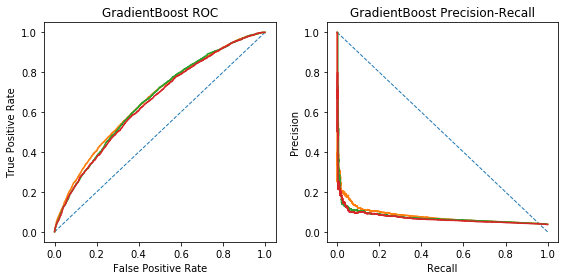

In [58]:
%%time
fig = plt.figure(figsize=(8, 4))
ax21 = fig.add_subplot(1, 2, 1)
ax22 = fig.add_subplot(1, 2, 2)

neutral_line = np.linspace(0, 1, 10)
ax21.plot(neutral_line, neutral_line, lw=1, ls='--')
ax22.plot(neutral_line, 1- neutral_line, lw=1, ls='--')

ginis_xgb = []

for i in range(3):

    rstate = None
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=rstate)

    num_class1 = np.sum(y_train)
    num_class1_to_resample = 2 * num_class1
    num_class0_to_resample = int(1 * num_class1_to_resample)

    # First, randomly undersample the majority
    rus = RandomUnderSampler(ratio={0: num_class0_to_resample , 1: num_class1})
    X_tlrus, y_tlrus = rus.fit_sample(X_train, y_train)

    # Then use SMOTE to oversample the minority
    smote = SMOTE(ratio={0: num_class0_to_resample , 1: num_class1_to_resample}, n_jobs=8)
    X_res, y_res = smote.fit_sample(X_tlrus, y_tlrus)

    # GradientBoost
    clf = best_xgb
    clf.fit(X_res, y_res)

    y_pred2 = clf.predict(X_test)
    y_proba2 = clf.predict_proba(X_test)
    ginis_xgb.append(my_gini(y_test, y_proba2))
    report2 = classification_report(y_test, y_pred2, digits=4,
                                   labels=None, target_names=None)

    precision2, recall2, _ = precision_recall_curve(y_test, y_proba2[:, 1], pos_label=1)
    fpr2, tpr2, _ = roc_curve(y_test, y_proba2[:, 1], pos_label=1)
    ax21.plot(fpr2, tpr2)
    ax21.set_xlabel('False Positive Rate')
    ax21.set_ylabel('True Positive Rate')
    ax21.set_title('GradientBoost ROC')
    ax22.plot(recall2, precision2)
    ax22.set_xlabel('Recall')
    ax22.set_ylabel('Precision')
    ax22.set_title('GradientBoost Precision-Recall')

plt.tight_layout()

print('Gini=%.3f+/-%.3f, Best=%.3f' % (np.mean(ginis_xgb), np.std(ginis_xgb), np.max(ginis_xgb)))